In [1]:
import numpy as np
import os
from astropy.io import fits
from astropy import wcs
import glob
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.lines import Line2D
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.optimize import curve_fit
os.chdir('code/')
import optical_overlay_plots as oop
import source_search as ss

In [2]:
os.chdir('/home/ddunne/Documents/research/ALMA/2019.1.01529.S/XMM/XMM-8/product/cubes')

xmm5_cubefiles = glob.glob("*.fits")

xmm5_cubehduls = []
for i,file in enumerate(xmm5_cubefiles):
    with fits.open(file) as hdulist:
        xmm5_cubehduls.append(hdulist)
        print("{} {}".format(i, file))

0 xmm8spw25combmom0.fits
1 c4d_180921_070358_oki_z_v1_extn=15_POS=36.112,-5.609_SIZE=0.1,0.1.fits
2 member.uid___A001_X1465_X8e7.XMM-8_sci.spw7.cube.I.pbcor.fits
3 member.uid___A001_X1465_X8e7.XMM-8_sci.spw21.cube.I.pbcor.fits
4 member.uid___A001_X1465_X8e7.XMM-8_sci.spw23.repBW.I.pb.fits
5 xmm8spw23mom0_1.fits
6 xmm8spw23mom0_2.fits
7 member.uid___A001_X1465_X8e7.XMM-8_sci.spw23.cube.I.pbcor.fits
8 member.uid___A001_X1465_X8e7.XMM-8_sci.spw23.cube.I.pb.fits
9 member.uid___A001_X1465_X8e7.XMM-8_sci.spw19.cube.I.pbcor.fits
10 xmm8spw23mom1.fits
11 member.uid___A001_X1465_X8e7.XMM-8_sci.spw23.repBW.I.pbcor.fits


# OVERLAY RADIO CONTOURS

In [60]:
hdul = fits.open(xmm5_cubefiles[1])
momwcs = wcs.WCS(hdul[0].header)

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [61]:
nuobs = hdul[0].header['cfreq']

# coordinate transformation from hz to km/s
freq_to_vel = u.doppler_radio(hdul[0].header['RESTFRQ']*u.Hz)
vel = (nuobs*u.Hz).to(u.km / u.s, equivalencies=freq_to_vel)

nuemit = hdul[0].header['restfrq']

z = (nuemit - nuobs)/nuobs
z

118176*u.km/u.s - vel

<Quantity 731.61982989 km / s>

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


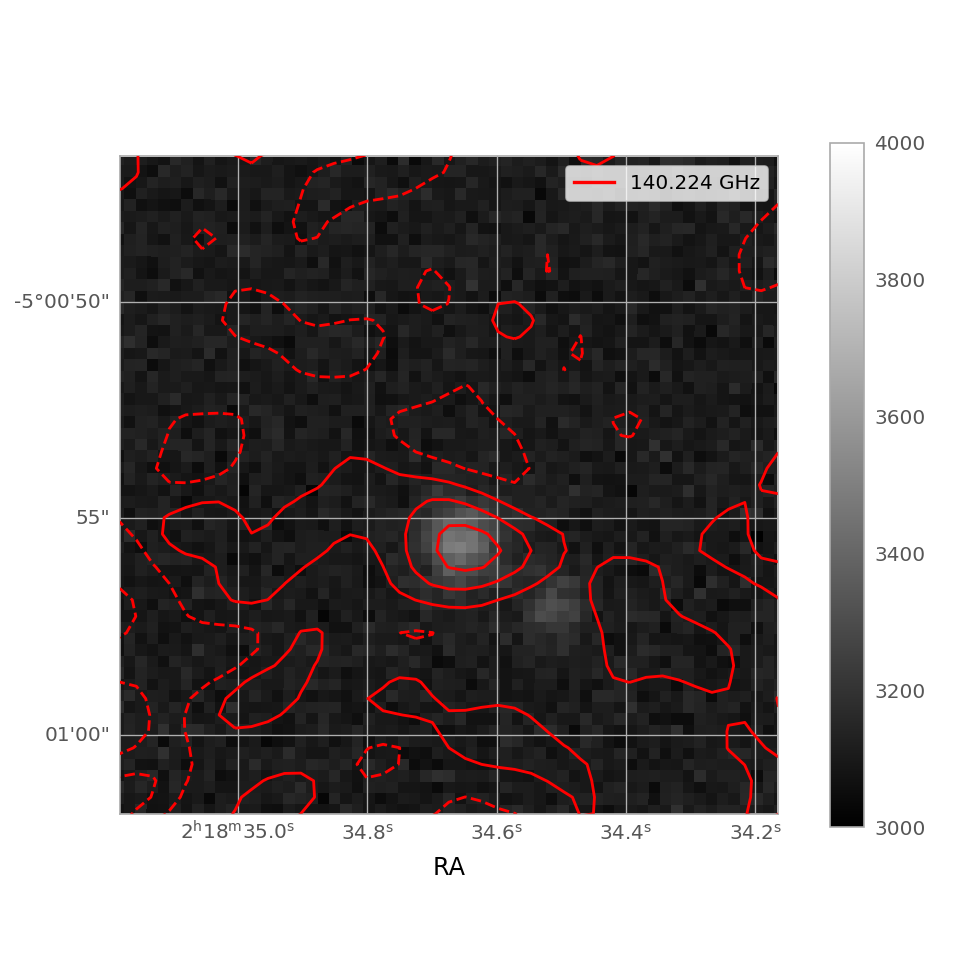

In [3]:
%matplotlib notebook
# ((optical file, moment file), vmin, vmax, (xcutout), (ycutout))
oop.plot_contour_overlay((xmm5_cubefiles[0], xmm5_cubefiles[1]), 3000, 4000, (65, 105), (50, 90), use_Hz=True)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


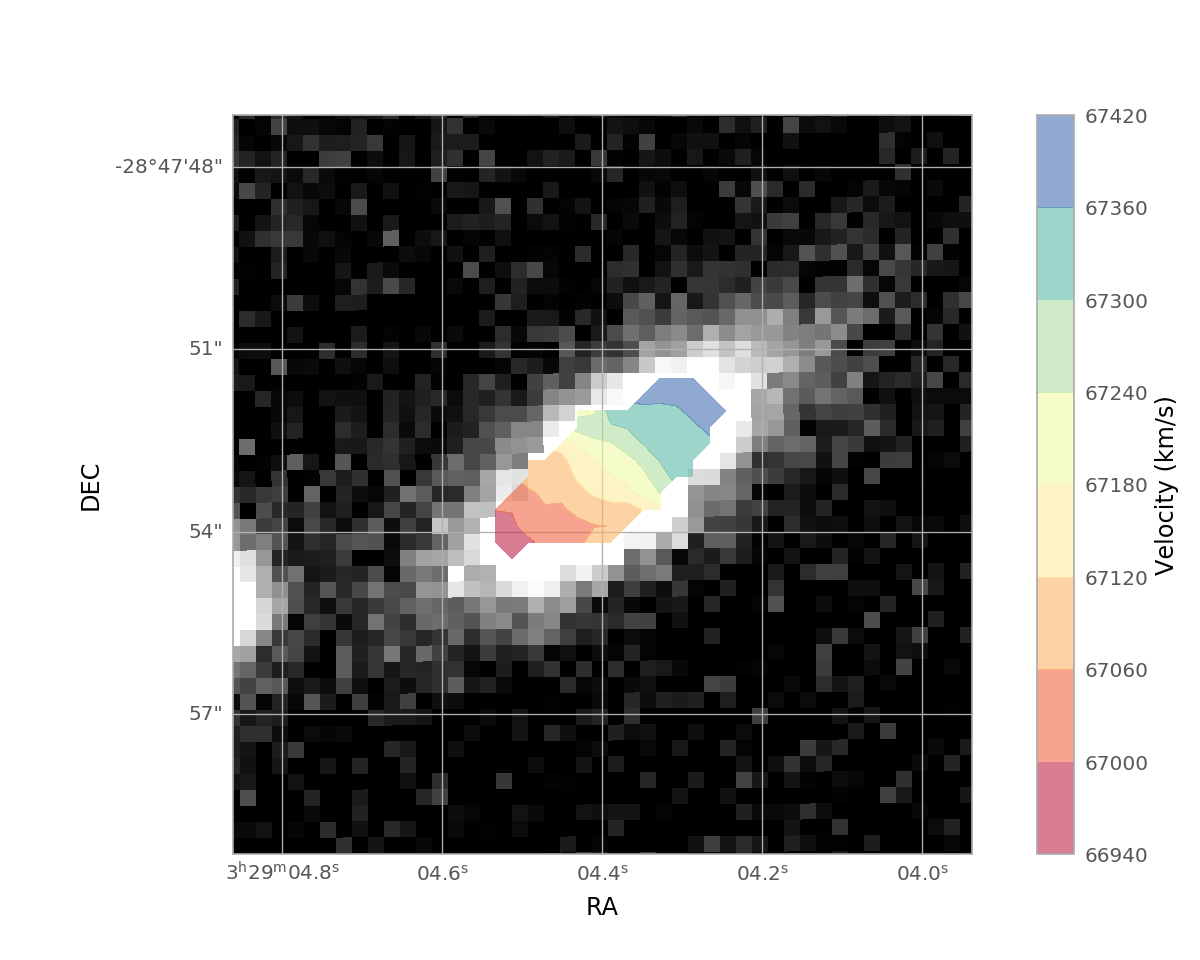

In [3]:
%matplotlib notebook
oop.plot_velocity_overlay((xmm5_cubefiles[10], xmm5_cubefiles[8]), 1350, 1500, (85, 130), (85, 130))

# SOURCE SEARCH ALGORITHM

In [2]:
from photutils import detect_sources, source_properties
#ref: https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.SourceProperties.html#photutils.segmentation.SourceProperties
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.colors import ListedColormap
from astropy.visualization import astropy_mpl_style
from astropy.convolution import Tophat2DKernel
from astropy.modeling.functional_models import Ellipse2D
from math import floor
plt.style.use(astropy_mpl_style)
import astropy.units as u
    

In [3]:
os.chdir('/home/ddunne/Documents/research/ALMA/2019.1.01529.S/XMM/XMM-5/product/cubes')

xmm5_cubefiles = glob.glob("*.fits")

xmm5_cubehduls = []
for i,file in enumerate(xmm5_cubefiles):
    with fits.open(file) as hdulist:
        xmm5_cubehduls.append(hdulist)
        print("{} {}".format(i, file))

0 member.uid___A001_X1465_X8db.XMM-5_sci.spw19.repBW.I.pb.fits
1 member.uid___A001_X1465_X8db.XMM-5_sci.spw19.cube.I.pb.fits
2 member.uid___A001_X1465_X8db.XMM-5_sci.spw19.cube.I.pbcor.fits
3 member.uid___A001_X1465_X8db.XMM-5_sci.spw9.cube.I.pbcor.fits
4 member.uid___A001_X1465_X8db.XMM-5_sci.spw11.cube.I.pbcor.fits
5 DESopticalXMM5.fits
6 member.uid___A001_X1465_X8db.XMM-5_sci.spw19.repBW.I.pbcor.fits
7 member.uid___A001_X1465_X8db.XMM-5_sci.spw7.cube.I.pbcor.fits
8 xmmspw19mom0.fits


In [5]:
os.chdir('/home/ddunne/Documents/research/ALMA/2019.1.01529.S/nodetections/full_cube')
cffiles = glob.glob("*.I.pbcor.fits")
for i, file in enumerate(cffiles):
    print(i, file)
    
cffiles = np.array(cffiles)

0 member.uid___A001_X1465_X90b.ES1-7_sci.spw17.cube.I.pbcor.fits
1 member.uid___A001_X1465_X92f.CDFS-6_sci.spw23.cube.I.pbcor.fits
2 member.uid___A001_X1465_X8d7.XMM-4_sci.spw23.cube.I.pbcor.fits
3 member.uid___A001_X1465_X947.CDFS-12_sci.spw25.cube.I.pbcor.fits
4 member.uid___A001_X1465_X93f.CDFS-10_sci.spw25.cube.I.pbcor.fits
5 member.uid___A001_X1465_X933.CDFS-7_sci.spw19.cube.I.pbcor.fits
6 member.uid___A001_X1469_X27a.ES1-5_sci.spw25.cube.I.pbcor.fits
7 member.uid___A001_X1465_X8e3.XMM-7_sci.spw25.cube.I.pbcor.fits
8 member.uid___A001_X1465_X93b.CDFS-9_sci.spw25.cube.I.pbcor.fits
9 member.uid___A001_X1469_X276.XMM-6_sci.spw19.cube.I.pbcor.fits
10 member.uid___A001_X1465_X923.CDFS-3_sci.spw23.cube.I.pbcor.fits


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


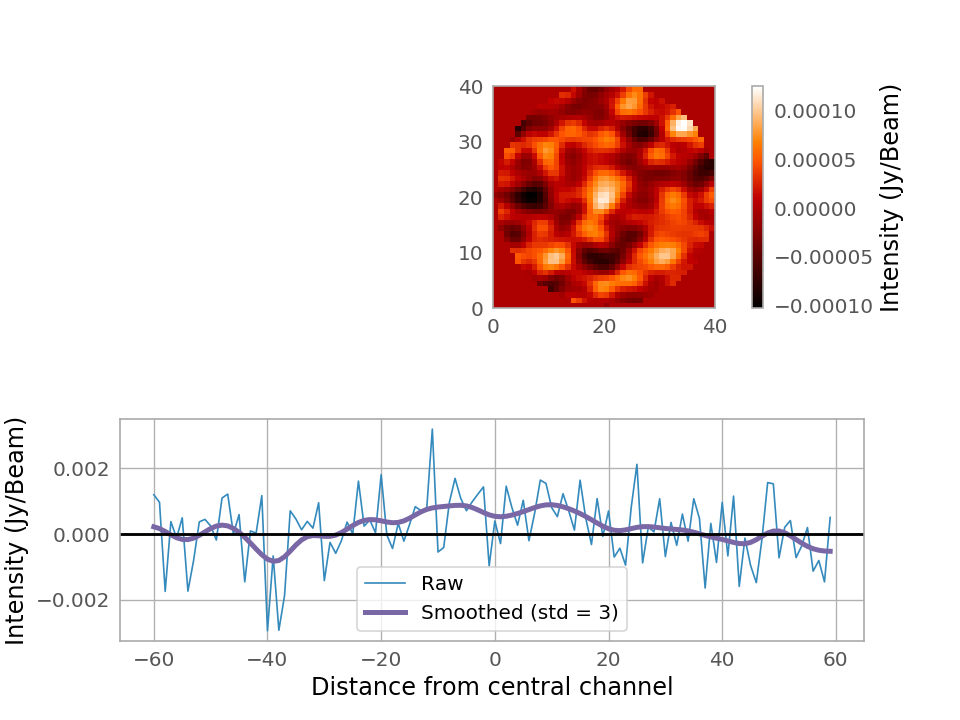

In [21]:
%matplotlib notebook
# (files, nchans, rwindow, profonly=False, imonly=False, sigma=None)
ss.image_stack(cffiles[np.array([6,7,8,9])], 120, 20, sigma=3);

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


38


<IPython.core.display.Javascript object>


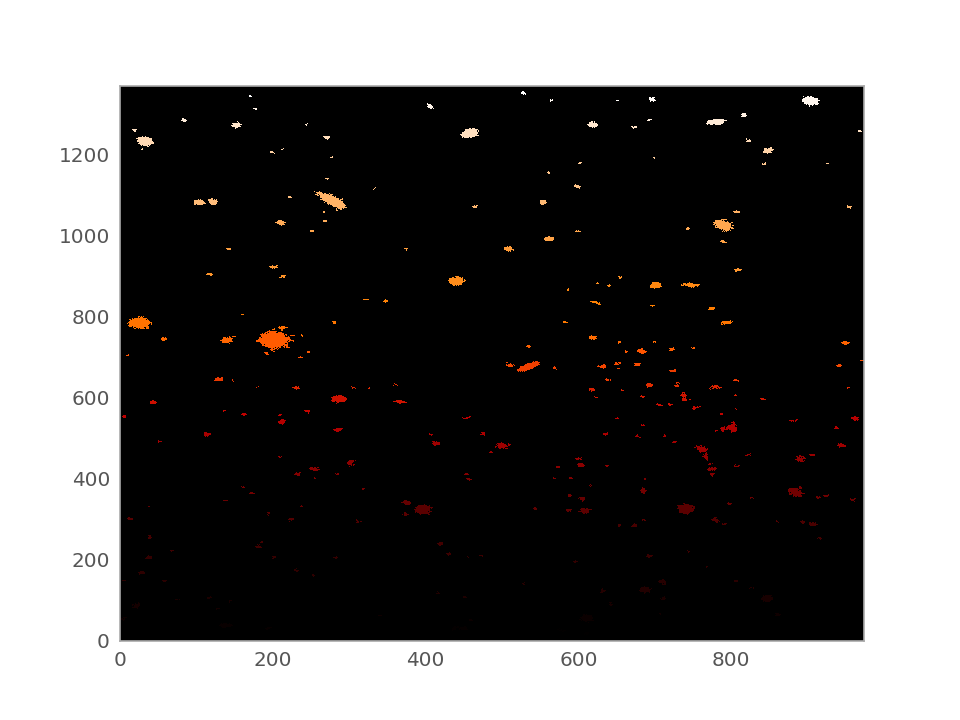

In [18]:
%matplotlib notebook
# findblobs(file, optfile, pbfile, opt threshold, nstds, npix, ndist)
xmm5sources, xmm5blobs, xmm5perims, xmm5poss, xmm5data, cocoords = ss.find_blobs(xmm5_cubefiles[5], xmm5_cubefiles[7], 
                                                                                 xmm5_cubefiles[3], 4, 12, 10, 0.15)

In [20]:
len(xmm5poss)

4

In [21]:
resposs = np.array(xmm5poss)
print(len(np.where(resposs[:, 8] != -1)[0]))

matchidx = np.where(resposs[:,8] != -1)

matchchans = resposs[matchidx, 0][0]
matchchans = np.array([int(x) for x in matchchans])
matchchans

2


array([28, 34])

In [22]:
# all channels with a source, no matter where it is 

schans = np.array([int(x) for x in xmm5poss[:,0]])
schans

array([18, 28, 34, 35])

In [86]:
cschans = find_consec(schans)
print(len(cschans))
cschans

68


array([  0,   1,  28,  29,  30,  35,  36,  41,  42,  45,  46,  48,  49,
        50,  66,  67,  68,  69,  80,  81,  94,  95,  98,  99, 106, 107,
       109, 110, 115, 116, 124, 125, 126, 127, 128, 132, 133, 135, 136,
       139, 140, 146, 147, 162, 163, 164, 170, 171, 172, 173, 174, 180,
       181, 182, 202, 203, 206, 207, 209, 210, 216, 217, 219, 220, 221,
       226, 227, 228])

<IPython.core.display.Javascript object>


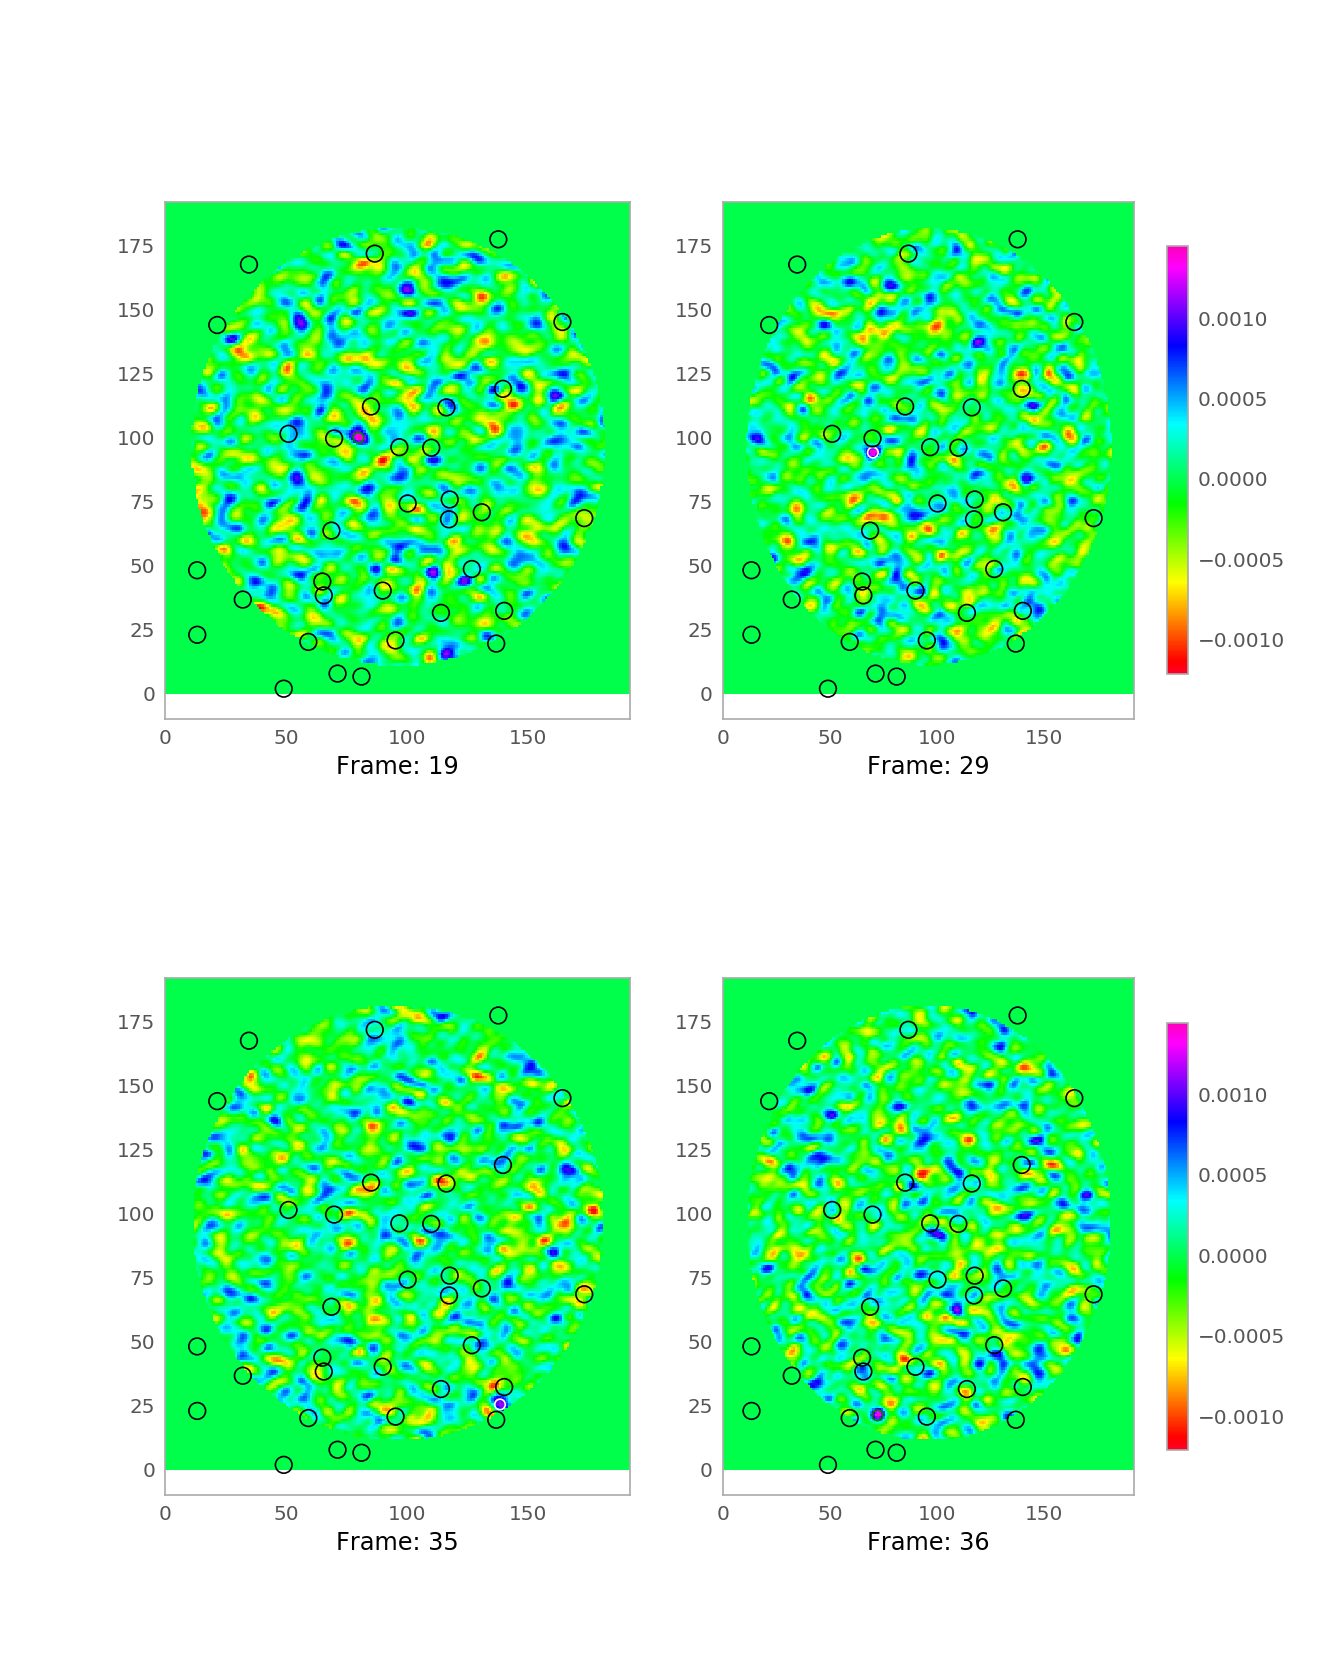

In [23]:
%matplotlib notebook

ss.blobVisualize(xmm5data, xmm5poss, cocoords, schans)

working on a search algorithm that finds sources in the same location in multiple consecutive frames

In [19]:
x = xmm5poss[5,1]
y = xmm5poss[5,2]

IndexError: index 5 is out of bounds for axis 0 with size 4

In [ ]:
poss = xmm5poss
nd = 10
n = 1

x = poss[n, 1]
y = poss[n, 2]
chan = poss[n,0]

# find all entries farther along than n that are similar in (x,y) coordinates
xcond = np.logical_and(poss[n:,1] < x+nd, poss[n:,1] > x-nd)
ycond = np.logical_and(poss[n:,2] < y+nd, poss[n:,2] > y-nd)

potmatches = np.where(np.logical_and(xcond, ycond))[0] + n

# find the channels each potential match belongs
potchans = poss[potmatches,0]

for nchanidx in np.arange(1, 10):
    nextchan = np.where(potchans == chan + nchanidx)
    if nextchan[0].size > 0:
        poss[n,8] = nchanidx
        poss[potmatches[np.where(potchans == potchans[nextchan])], 8] = nchanidx
        continue
    else:
        print(nchanidx)
        break

# matchidx = potmatches[np.where(poss[potmatches, 0] != n)]

# poss[matchidx, 8] = n

# poss[np.where(poss[potmatches, 0] != n), 8]

# CO Mass Determination

## Process:
- first get Moment 0 map with CASA
- fit this to a 2D Gaussian (elliptical) - get FWHM for major and minor axes both
- use these to define a $4\sigma$ elliptical region about the center of the source in the full image cube
- get the spectral profile of the image cube in this region
- model this spectral profile with a Gaussian
- area under Gaussian is full integrated source flux

This should agree to a reasonable degree with the peak flux of the Moment map

In [2]:
os.chdir('/home/ddunne/Documents/research/ALMA/code')
import co_masses as co
import astropy.units as u

In [52]:
# load in all files in the Galaxy's product cube directory
os.chdir('/home/ddunne/Documents/research/ALMA/2019.1.01529.S/XMM/XMM-2/product/cubes')

xmm5_cubefiles = glob.glob("*.fits")

xmm5_cubehduls = []
for i,file in enumerate(xmm5_cubefiles):
    with fits.open(file) as hdulist:
        xmm5_cubehduls.append(hdulist)
        print("{} {}".format(i, file))

0 member.uid___A001_X1465_X8cf.XMM-2_sci.spw25.repBW.I.pb.fits
1 member.uid___A001_X1465_X8cf.XMM-2_sci.spw21.cube.I.pbcor.fits
2 DES0215-0416_r2577p01_z_extn=1_POS=33.9327,-4.41478_SIZE=0.1,0.1.fits
3 member.uid___A001_X1465_X8cf.XMM-2_sci.spw25.cube.I.pb.fits
4 member.uid___A001_X1465_X8cf.XMM-2_sci.spw25.repBW.I.pbcor.fits
5 member.uid___A001_X1465_X8cf.XMM-2_sci.spw25.cube.I.pbcor.fits
6 member.uid___A001_X1465_X8cf.XMM-2_sci.spw19.cube.I.pbcor.fits
7 member.uid___A001_X1465_X8cf.XMM-2_sci.spw23.cube.I.pbcor.fits


In [16]:
scihdul = fits.open(xmm5_cubefiles[4])
sci = scihdul[0].data
sci[np.where(np.isnan(sci))] = 0.
sci = sci[0,0,:,:]
sciwcs = wcs.WCS(scihdul[0].header)

# prepare coordinates to get the fitted mask
scix = np.arange(np.shape(sci)[0])
scicoords = np.stack(np.meshgrid(scix, scix), axis=2).astype('float64')

<IPython.core.display.Javascript object>


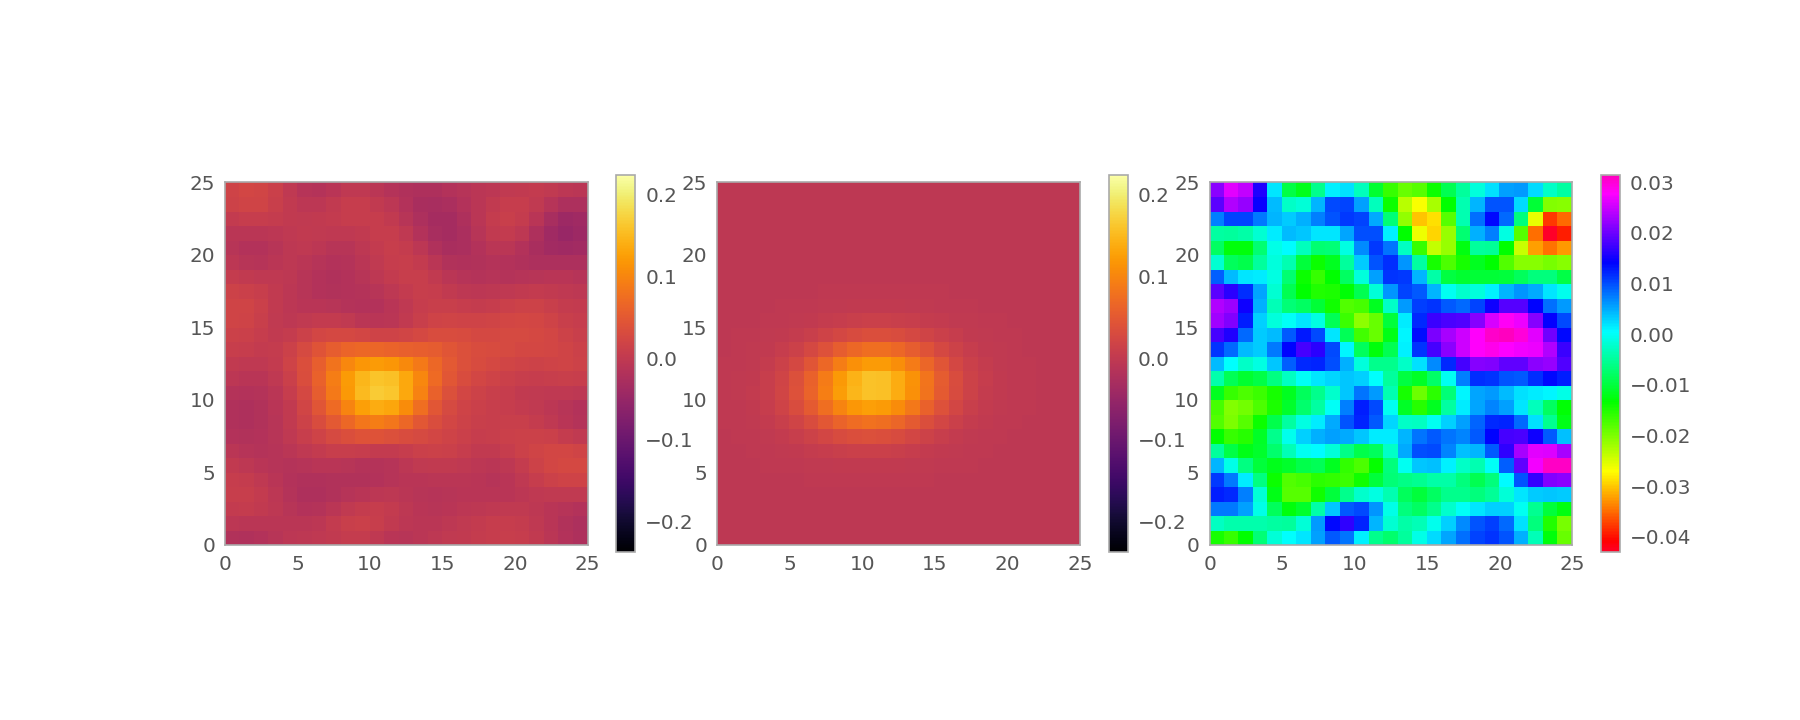

In [19]:
%matplotlib notebook
co.plot_gauss_fit(sci, scicoords, (95, 120))

In [35]:
sigx, sigy = co.get_FWHMa(sci, (90,120))

<IPython.core.display.Javascript object>


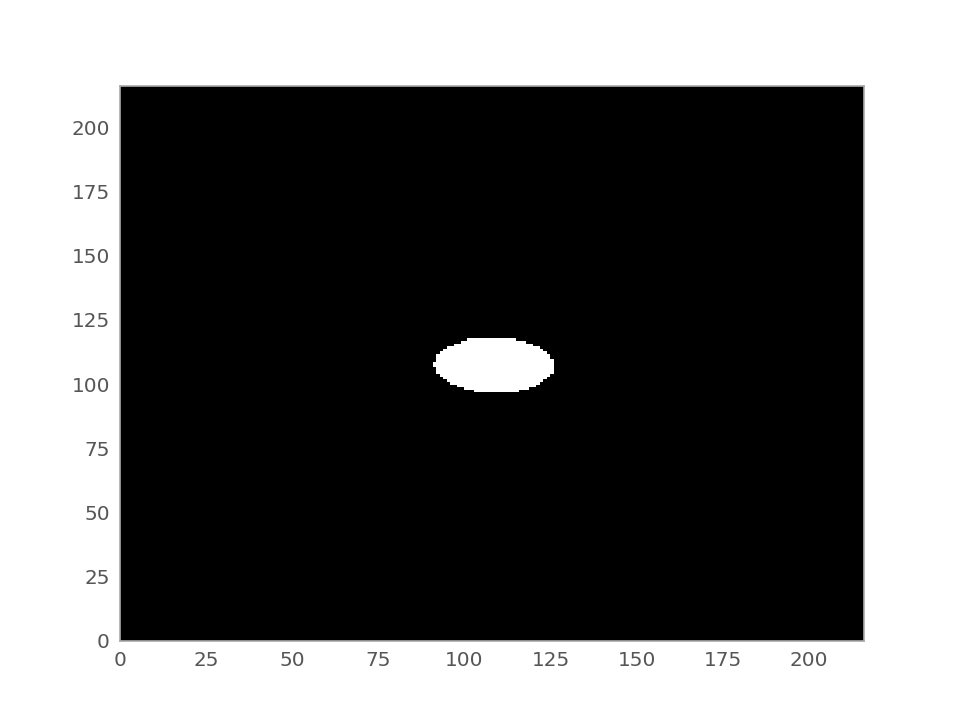

In [14]:
%matplotlib notebook

plt.pcolormesh(co.line_mask(sci, (90,120), True)[0])

## get spectral profile of the emission inside the range determined by the line_mask function over the full image cube

I THINK we want the moment 0 of each individual channel:

\begin{equation}
M_0 = \Delta \nu \sum I_i
\end{equation}

where $\Delta \nu$ is the bandwidth of the channel in whatever WCS units we choose to use (km/s?) and $I_i$ is the brightness value of the I'th pixel. Then plot this as a function of frequency?

- the brightness in each pixel is in units of Jy/beam
- frequency currently in hertz
- help with unit stuff: https://keflavich-astropy.readthedocs.io/en/latest/units/equivalencies.html
- beam axes are stored in the header as 'BMAJ' and 'BMIN'

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


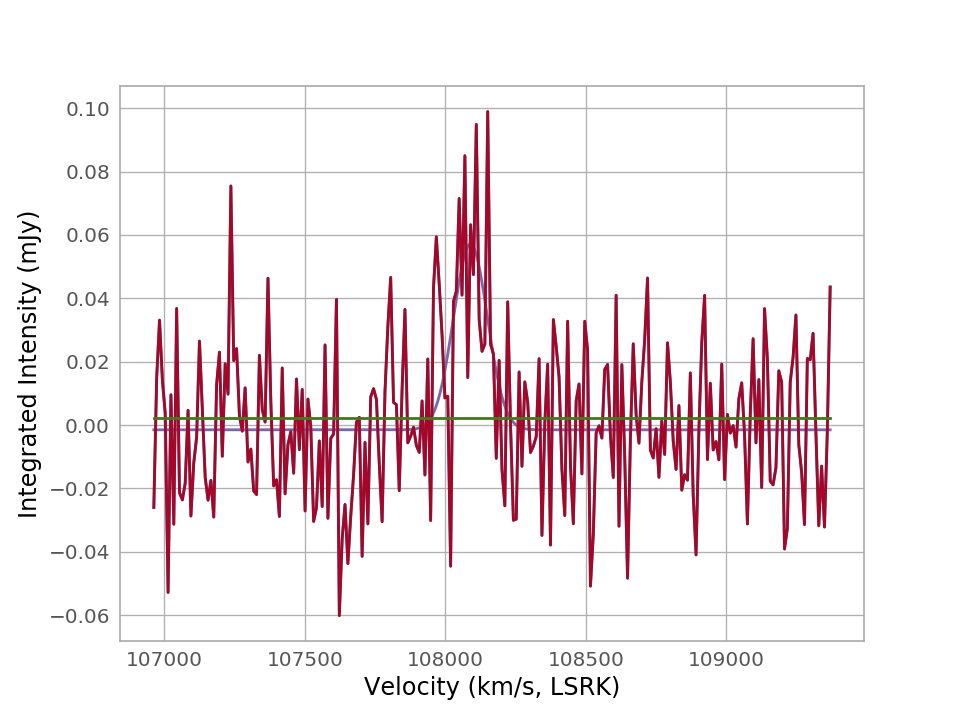

From peak intensity of Moment 0 map: 5.022822080251968 Jy km / s
From area under spectral profile fit: 8.860964213457498 Jy km / s


In [7]:
%matplotlib notebook
# (momentfile, cubefile, cutout, p0, usestds = true)
mommax, specmax, mean = co.get_velocity_int_flux(xmm5_cubefiles[7], xmm5_cubefiles[3], (95,120), [0.04, 50, 200, 0])
print("From peak intensity of Moment 0 map: {}".format(mommax))
print("From area under spectral profile fit: {}".format(specmax))

Get the CO line luminosity from this velocity integrated flux with equation 3 in Solomon and Vanden Bout (2005). This requires a luminosity distance, which in turn depends on the cosmology. Define a cosmology based on the Webb 2015 SpARCS 1049 discovery paper: $\Omega_0 = 1$, $\Omega_\Lambda=0.7$, $H_0 = 75km\cdot s^{-1} \cdot Mpc^{-1}$

In [6]:
lco = co.co_line_luminosity(specmax, centerfreq, z)

NameError: name 'centerfreq' is not defined

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


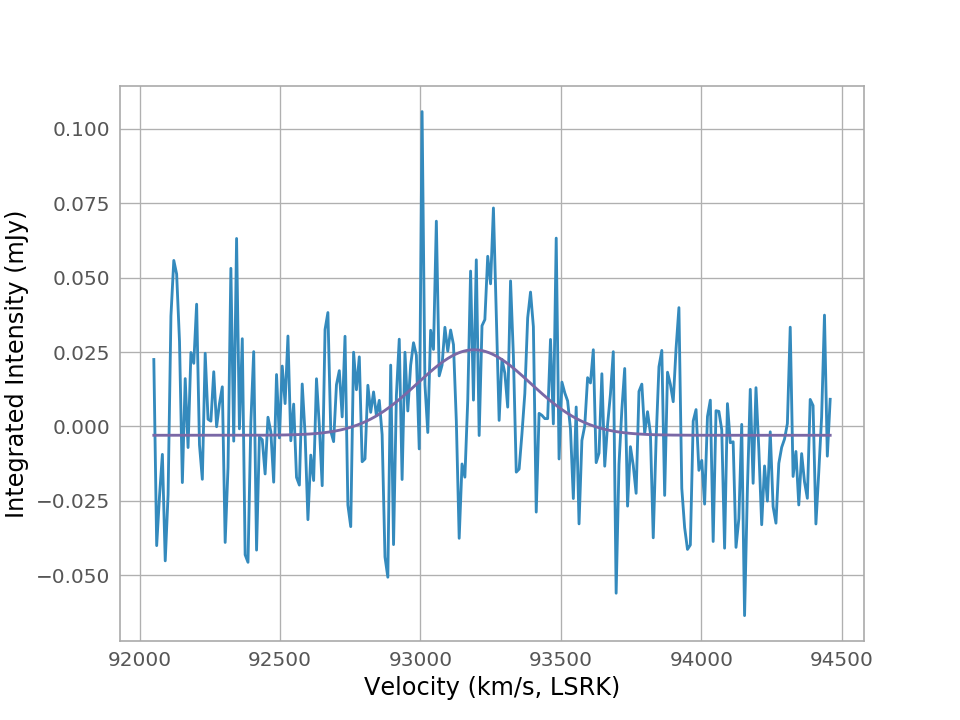

39373122270.56655

In [40]:
%matplotlib notebook
# momentfile, cubefile, z, p0
co.get_M_gas(xmm5_cubefiles[3], xmm5_cubefiles[4], 0.45114)#, p0=[0.03, 10, 50, 0])

In [5]:
# load in all files in the Galaxy's product cube directory
os.chdir('/home/ddunne/Documents/research/ALMA/2019.1.01529.S/nodetections/full_cube')

xmm5_cubefiles = glob.glob("*.fits")

xmm5_cubehduls = []
for i,file in enumerate(xmm5_cubefiles):
    with fits.open(file) as hdulist:
        xmm5_cubehduls.append(hdulist)
        print("{} {}".format(i, file))

0 member.uid___A001_X1465_X90b.ES1-7_sci.spw17.cube.I.pbcor.fits
1 member.uid___A001_X1465_X92f.CDFS-6_sci.spw23.cube.I.pbcor.fits
2 member.uid___A001_X1465_X8d7.XMM-4_sci.spw23.cube.I.pbcor.fits
3 member.uid___A001_X1465_X947.CDFS-12_sci.spw25.cube.I.pbcor.fits
4 member.uid___A001_X1465_X93f.CDFS-10_sci.spw25.cube.I.pbcor.fits
5 member.uid___A001_X1465_X933.CDFS-7_sci.spw19.cube.I.pbcor.fits
6 member.uid___A001_X1469_X27a.ES1-5_sci.spw25.cube.I.pbcor.fits
7 member.uid___A001_X1465_X8e3.XMM-7_sci.spw25.cube.I.pbcor.fits
8 member.uid___A001_X1465_X93b.CDFS-9_sci.spw25.cube.I.pbcor.fits
9 member.uid___A001_X1469_X276.XMM-6_sci.spw19.cube.I.pbcor.fits
10 member.uid___A001_X1465_X923.CDFS-3_sci.spw23.cube.I.pbcor.fits


In [7]:
from scipy.ndimage import gaussian_filter1d

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


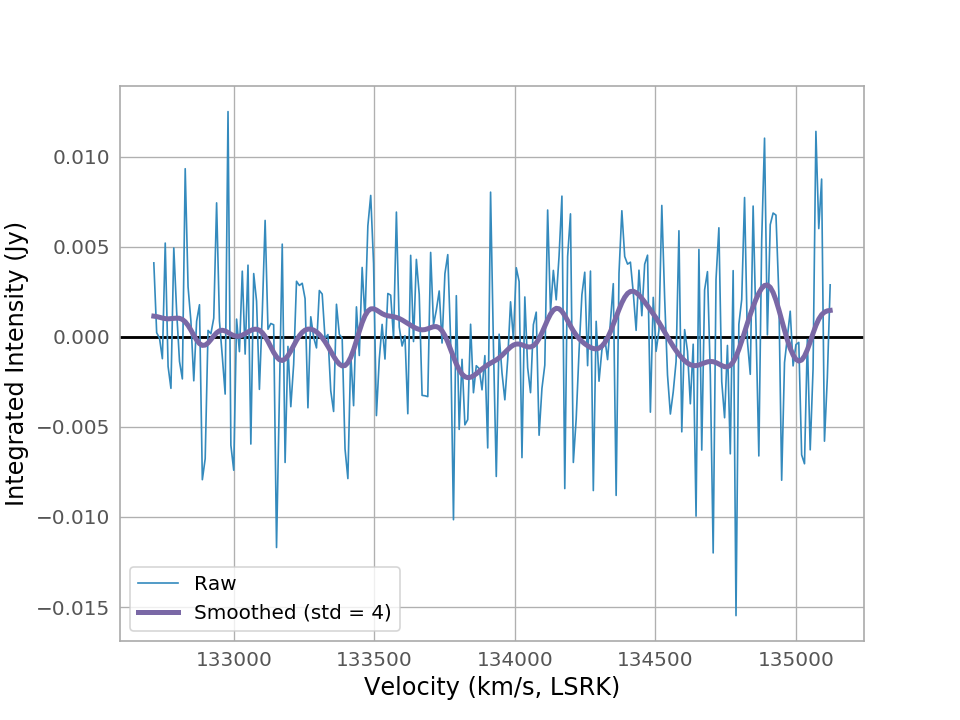

In [20]:
%matplotlib notebook
# (file, nFWHMa, sigma=None)
co.plot_spectral_profile(xmm5_cubefiles[10], 2, 4)

## Image Stacking 

- find the centroids of each target
- determine a region around each to look at 
- clip out that region
- take a mean
- show profile in a subplot?

In [22]:
data = np.ones((1, 4, 4))

In [23]:
extdata = np.zeros(data.shape + np.array([0, 2, 2]))

In [24]:
extdata.shape

(1, 6, 6)

In [25]:
def opt_image_stack(files, optfiles, nchans, rwindow, profonly = False, imonly = False, sigma=None, 
                    noptstds=0.25):
    
    ''' Function to find all the sources in an optical image that fall into the FoV of a pointing, and 
        to stack a circular window with radius rwindow around each of their centroids to see if theres
        faint flux at any of the locations.
        
        INPUTS: files: image cube files
                optfiles: optical files (MUST BE IN THE SAME ORDER AS THE FILES)
    '''
    
    nfiles = len(files)
    chanrange = nchans // 2
    
    # define a circular window about the center of the file to integrate over to get the spectral profile
    window = Ellipse2D(1, 80, 80, rwindow, rwindow, 0)
    # to get an actual array, need to pass it a meshgrid of x and y coordinates
    datx = np.arange(160)
    x, y = np.meshgrid(datx, datx)
    
    # load all image data into a single master image cube, placing channels the same distance from the center 
    # next to each other
    mcube = []
    mprof = []
    
    for i, file in enumerate(files):
        hdu = fits.open(file)[0]
        data = hdu.data
        datawcs = wcs.WCS(hdu.header).sub(['celestial'])
        # remove the empty stokes axis and keep only the channels and pixels around the center
        data = data[0,:,:,:]
        # map nans to zero
        data[np.where(np.isnan(data))] = 0.
        
        # find the source centroids of the related optical file (in skycoords)
        optcoords, sources, optwcs = ss.find_optical_centroids(optfiles[i], noptstds, 10) #****
        
        # change the centroid values to native image cube pixels
        optcoords = optcoords.to_pixel(datawcs)
        
        # the channel indices apply for all sourcse in the file
        centchan = data.shape[0] //2
        minc, maxc = centchan - chanrange, centchan + chanrange
        
        data = data[minc:maxc, :, :]
        
        # slap the whole data array into a larger array of zeros, so if the sources are 
        # too close to the edge they'll just pick up extra zeros, which won't affect the statistics
        extdata = np.zeros(data.shape + np.array([0, 160, 160]))
        extdata[:, 80:-80, 80:-80] = data
        
        
        # SOME SORT OF VERIFICATION SYSTEM?
        # loop through the optical sources in the file and cut out a window around each
        for j in range(len(optcoords)):
            
            centx = optcoords[j, 0] + 80
            centy = optcoords[j, 1] + 80
            
            
            
            
            
            minx, maxx = centx, centx + 160
            miny, maxy = centy, centy + 160
                
            sdata = extdata[:, minx:maxx, miny:maxy]
            
            # multiply data by window to get only the desired area around the center
            sdata = sdata * window(x,y)


            # change rwindow into arcseconds according to the specific wcs of each image to divide
            # by the area of the window when making the spectral profile
            # here need the actual pixel values of the center so subtract 80 again
            centx -= 80
            centy -= 80
            skycoordx1, skycoordx2 = datawcs.pixel_to_world([[centx, centy], 
                                                             [centx + rwindow, centy + rwindow]], 
                                                            [centx, centy])
            # semi-major and -minor axes in arcseconds
            rega = skycoordx2.separation(skycoordx1).to(u.arcsec)[0]
            regb = skycoordx2.separation(skycoordx1).to(u.arcsec)[1]

            # area of the window region in arcseconds squared
            areg = np.pi * rega * regb

    #         # find beam area and multiply by the beam?
    #         abeam = (np.pi*hdu.header['BMAJ']*hdu.header['BMIN'] * u.deg**2).to(u.arcsec**2).value
        
            # for each optical source in the cube, get an individual spectral profile of the data in the window
            # by summing over both spatial axes
            prof = np.sum(sdata, axis=(1,2)) / areg
            mprof.append(prof)
        
            # append onto mcube
            if i == 0 and j == 1:
                mcube = sdata
            else: 
                mcube = np.concatenate((mcube, sdata), axis=0)
            
            # END for coord in optcoords
            # END for file in files

    
    ''' for the first subplot: single large average over all relevant channels (centered around the center of each cube) '''
    
    # average down the channel axis
    avg = np.mean(mcube, axis=0)
    
    ''' second subplot: spectral profile of pix in window - average down the list of files '''
    mprof = np.array(mprof)
    
    avgprof = np.mean(mprof, axis=0)
    
    # add smoothing as an option
    if sigma is not None:
        avgprofsm = gaussian_filter1d(avgprof, sigma=sigma, truncate=5)
    
    # also have to divide by area over which you're integrating
    
    if imonly == True:
        ''' plot first only'''
        fig,axs = plt.subplots(1, figsize=(8, 6))

        xmin, xmax = 80 - rwindow, 80 + rwindow

        im = axs.pcolormesh(avg[xmin:xmax, xmin:xmax])
        axs.set_aspect(aspect=1)
        cbar = plt.colorbar(im, ax=axs)
        cbar.ax.set_ylabel('Intensity (Jy/Beam)')
        
        
    elif profonly == True:
        
        fig,axs = plt.subplots(1, figsize=(9,6))
        
        axs.plot(np.arange(-chanrange, chanrange), avgprof, lw=1, label='Raw')
        
        if sigma is not None:
            axs.plot(np.arange(-chanrange, chanrange), avgprofsm, lw=3, label='Smoothed (std = {})'.format(sigma))
            axs.legend()
        axs.axhline(0, color='k')
        axs.set_ylabel('Intensity (Jy/Beam)')
        axs.set_xlabel('Distance from Central Channel')
        
    else:

        ''' plot first'''
        fig,axs = plt.subplots(2, figsize=(8, 6))

        xmin, xmax = 80 - rwindow, 80 + rwindow

        im = axs[0].pcolormesh(avg[xmin:xmax, xmin:xmax])
        axs[0].set_aspect(aspect=1)
        cbar = plt.colorbar(im, ax=axs[0])
        cbar.ax.set_ylabel('Intensity (Jy/Beam)')



        ''' plot second'''
        axs[1].plot(np.arange(-chanrange, chanrange), avgprof, lw=1, label='Raw')
        if sigma is not None:
            axs[1].plot(np.arange(-chanrange, chanrange), avgprofsm, lw=3, label='Smoothed (std = {})'.format(sigma))
            axs[1].legend()
        axs[1].axhline(0, color='k')
        axs[1].set_ylabel('Intensity (Jy/Beam)')
        axs[1].set_xlabel('Distance from central channel')
    


                          
        
    return avg, avgprof